# Book Recommendation System: Collaborative Filtering
This notebook builds a book recommendation system using collaborative filtering techniques.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import Counter

## Step 1 & 2: Load and Inspect the Dataset

In [4]:
# Load sample data (synthetic for demo)
ratings = pd.DataFrame({
    'user_id': np.random.randint(1, 21, 100),
    'book_id': np.random.randint(1, 21, 100),
    'rating': np.random.randint(1, 6, 100)
})
books = pd.DataFrame({
    'book_id': range(1, 21),
    'title': [f"Book {i}" for i in range(1, 21)],
    'author': [f"Author {i}" for i in range(1, 21)]
})
ratings.head(10), books.head(10)

(   user_id  book_id  rating
 0       11       11       1
 1       10       10       3
 2       15        9       1
 3        3       20       1
 4       17        4       3
 5       12       20       3
 6        6        4       5
 7       20        9       5
 8       20       11       2
 9        2        9       4,
    book_id    title     author
 0        1   Book 1   Author 1
 1        2   Book 2   Author 2
 2        3   Book 3   Author 3
 3        4   Book 4   Author 4
 4        5   Book 5   Author 5
 5        6   Book 6   Author 6
 6        7   Book 7   Author 7
 7        8   Book 8   Author 8
 8        9   Book 9   Author 9
 9       10  Book 10  Author 10)

## Step 3: Plot the Distribution of Book Ratings

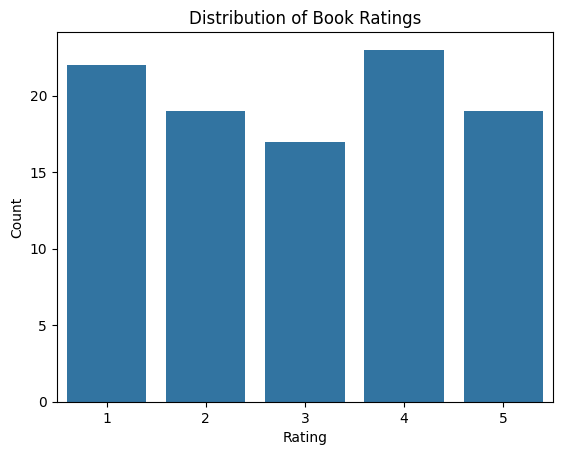

In [5]:
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Step 4: Data Preparation - Create User-Item Matrix

In [6]:
user_item_matrix = ratings.pivot_table(index='user_id', columns='book_id', values='rating')
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix.head()

book_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
user_id,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,1.0,0.0,3.0
2,0.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
4,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Step 5: Collaborative Filtering - Compute Similarities & Recommend

In [7]:
user_sim_matrix = cosine_similarity(user_item_matrix)
user_sim_df = pd.DataFrame(user_sim_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_books(user_id, user_sim_df, user_item_matrix, books, n_recommendations=5):
    sim_users = user_sim_df[user_id].drop(index=user_id)
    top_users = sim_users.sort_values(ascending=False).head(5).index
    weighted_ratings = user_item_matrix.loc[top_users].T.dot(sim_users[top_users])
    normalization = sim_users[top_users].sum()
    predicted_ratings = weighted_ratings / normalization

    user_read = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = predicted_ratings.drop(user_read).sort_values(ascending=False).head(n_recommendations)
    return books[books['book_id'].isin(recommendations.index)]

# Example recommendation
recommend_books(1, user_sim_df, user_item_matrix, books)

,book_id,title,author
1,2,Book 2,Author 2
3,4,Book 4,Author 4
4,5,Book 5,Author 5
8,9,Book 9,Author 9
11,12,Book 12,Author 12


## Step 6: Evaluation Using MSE

In [8]:
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
train_matrix = train_data.pivot_table(index='user_id', columns='book_id', values='rating').fillna(0)
user_sim_train = cosine_similarity(train_matrix)
user_sim_df_train = pd.DataFrame(user_sim_train, index=train_matrix.index, columns=train_matrix.index)

# Predict ratings for test set
y_true, y_pred = [], []
for _, row in test_data.iterrows():
    user, book, true_rating = row['user_id'], row['book_id'], row['rating']
    if user in user_sim_df_train.index and book in train_matrix.columns:
        sims = user_sim_df_train[user].drop(index=user)
        top_users = sims.sort_values(ascending=False).head(5).index
        top_ratings = train_matrix.loc[top_users, book]
        valid = top_ratings[top_ratings > 0]
        if not valid.empty:
            pred = np.dot(valid, sims[valid.index]) / sims[valid.index].sum()
            y_true.append(true_rating)
            y_pred.append(pred)

mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 2.0488


## Step 7: Visualizations and Insights

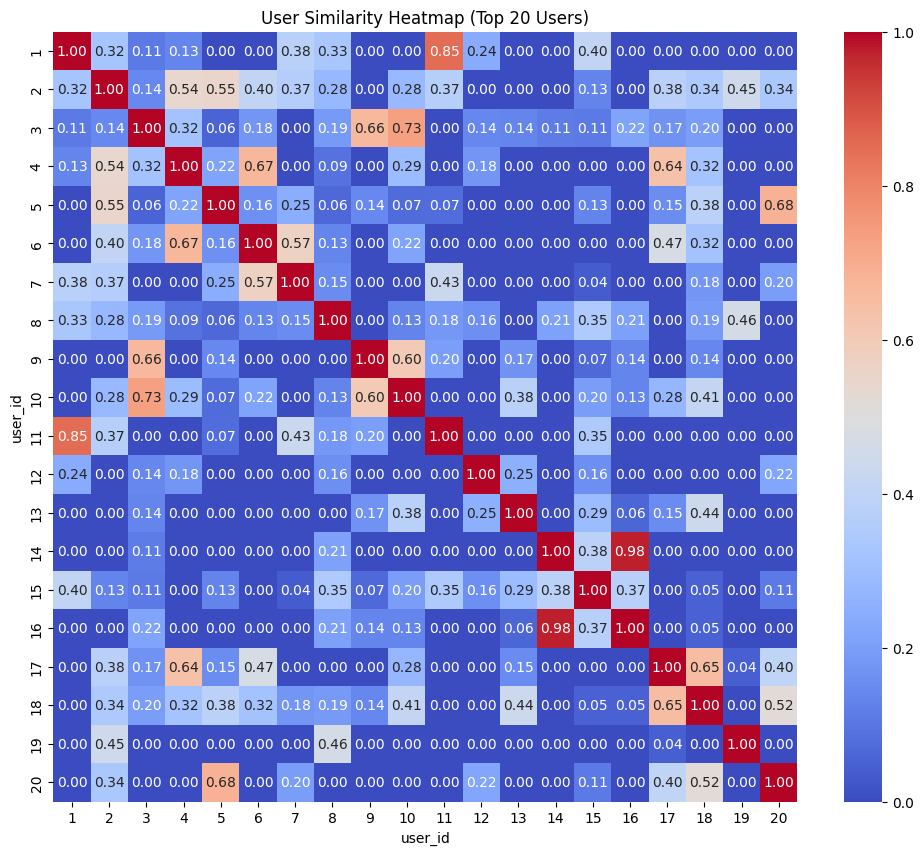

In [9]:
# Heatmap of user similarity
subset_sim = user_sim_df_train.iloc[:20, :20]
plt.figure(figsize=(12, 10))
sns.heatmap(subset_sim, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("User Similarity Heatmap (Top 20 Users)")
plt.show()

In [10]:
# Analyze most recommended books
recommendation_counter = Counter()
for user in train_matrix.index:
    sims = user_sim_df_train[user].drop(index=user)
    top_users = sims.sort_values(ascending=False).head(5).index
    weighted_ratings = train_matrix.loc[top_users].T.dot(sims[top_users])
    normalization = sims[top_users].sum()
    predicted_ratings = weighted_ratings / normalization
    recommended_books = predicted_ratings.sort_values(ascending=False).head(5).index
    recommendation_counter.update(recommended_books)

top_recommended_books = pd.DataFrame.from_dict(recommendation_counter, orient='index', columns=['count'])
top_recommended_books = top_recommended_books.sort_values(by='count', ascending=False).head(10)
top_recommended_books = top_recommended_books.merge(books, left_index=True, right_on='book_id')
top_recommended_books[['book_id', 'title', 'author', 'count']]

,book_id,title,author,count
3,4,Book 4,Author 4,14
8,9,Book 9,Author 9,12
6,7,Book 7,Author 7,10
13,14,Book 14,Author 14,9
5,6,Book 6,Author 6,8
17,18,Book 18,Author 18,8
16,17,Book 17,Author 17,6
12,13,Book 13,Author 13,5
7,8,Book 8,Author 8,5
9,10,Book 10,Author 10,5
